In [2]:
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
#import pyfolio
import datetime
%matplotlib inline

In [3]:
# Extract columns from dataframe
df_cur1 = pd.read_csv('data/2012-2017_EU.csv')
cur1_col1 = df_cur1.iloc[:, 4].values
cur1_index = df_cur1.iloc[:, 0].values
cur1_volume = df_cur1.iloc[:, 5].values
#cur1_col2 = df_cur1.iloc[1]

ii = 0
for i in range(len(cur1_col1)):
    if cur1_volume[i] > 0:
        cur1_col1[ii] = cur1_col1[i]
        ii += 1

df_cur2 = pd.read_csv('data/2012-2017_EC.csv')
cur2_col1 = df_cur2.iloc[:, 4].values
cur2_index = df_cur2.iloc[:, 0].values
cur2_volume = df_cur2.iloc[:, 5].values
#cur2_col2 = df_cur2.iloc[1]

jj = 0
for j in range(len(cur2_col1)):
    if cur2_volume[j] > 0:
        cur2_col1[jj] = cur2_col1[j]
        jj += 1

print(cur1_index[:1])
print(cur2_index[:1])

['02.01.2012 00:00:00.000']
['02.01.2012 00:00:00.000']


In [91]:
# Sample size parameter
samplesize = 200

# Array inits
other_ratio, this_ratio, cur1_localmax, cur2_localmax, cur1_localmin, cur2_localmin = ([] for i in range(6))

# Speed measuring
ping = time.process_time()

# First calc
cur1_localmax.insert(0, float(max(cur1_col1[:samplesize])))
cur2_localmax.insert(0, float(max(cur2_col1[:samplesize])))
cur1_localmin.insert(0, float(min(cur1_col1[:samplesize])))
cur2_localmin.insert(0, float(min(cur2_col1[:samplesize])))

for i in range(samplesize, len(cur1_col1)):
    # Get localmaxes and localmins respectively from extracted datasets

    # Array boundary precausions
    if i > 0: 
        # Cur1 max
        if cur1_col1[i] > cur1_localmax[i-samplesize-1]:
            cur1_localmax.insert(i-samplesize, cur1_col1[i])
        elif cur1_localmax[i-samplesize-1] == cur1_col1[i-samplesize-1]:
            cur1_localmax.insert(i-samplesize, float(max(cur1_col1[i-samplesize:i])))
        else:
            cur1_localmax.insert(i-samplesize, cur1_localmax[i-samplesize-1])
        
        # Cur2 max
        if cur2_col1[i] > cur2_localmax[i-samplesize-1]:
            cur2_localmax.insert(i-samplesize, cur2_col1[i])
        elif cur2_localmax[i-samplesize-1] == cur2_col1[i-samplesize-1]:
            cur2_localmax.insert(i-samplesize, float(max(cur2_col1[i-samplesize:i])))
        else:
            cur2_localmax.insert(i-samplesize, cur2_localmax[i-samplesize-1])
        
        # Cur1 min
        if cur1_col1[i] < cur1_localmin[i-samplesize-1]:
            cur1_localmin.insert(i-samplesize, cur1_col1[i])
        elif cur1_localmin[i-samplesize-1] == cur1_col1[i-samplesize-1]:
            cur1_localmin.insert(i-samplesize, float(min(cur1_col1[i-samplesize:i])))
        else:
            cur1_localmin.insert(i-samplesize, cur1_localmin[i-samplesize-1])
        
        # Cur2 min
        if cur2_col1[i] < cur2_localmin[i-samplesize-1]:
            cur2_localmin.insert(i-samplesize, cur2_col1[i])
        elif cur2_localmin[i-samplesize-1] == cur2_col1[i-samplesize-1]:
            cur2_localmin.insert(i-samplesize, float(min(cur2_col1[i-samplesize:i])))
        else:
            cur2_localmin.insert(i-samplesize, cur2_localmin[i-samplesize-1])
        
        # Calculate ratios
        o_r = (cur2_col1[i] - cur2_localmin[i-samplesize-1])/(cur2_localmax[i-samplesize-1] - cur2_localmin[i-samplesize-1])
        t_r = (cur1_col1[i] - cur1_localmin[i-samplesize-1])/(cur1_localmax[i-samplesize-1] - cur1_localmin[i-samplesize-1])
        # Prevent o_r !E {[0,1]}
        if o_r > 1:
            other_ratio.insert(i-samplesize, 1)
        elif o_r < 0:
            other_ratio.insert(i-samplesize, 0)
        else:
            other_ratio.insert(i-samplesize, o_r)
            
        if t_r > 1:
            this_ratio.insert(i-samplesize, 1)
        elif t_r < 0:
            this_ratio.insert(i-samplesize, 0)
        else:
            this_ratio.insert(i-samplesize, t_r)
            
        # Simple progress bar
        if i % (math.floor((len(cur1_col1)-1-samplesize)/10)) == 0:
            print('+ '*math.ceil(((len(cur1_col1)-1-samplesize)/10/i)**-1),
                  '- '*(10-math.ceil(((len(cur1_col1)-1-samplesize)/10/i)**-1)), sep='')

# Print elapsed time
pong = time.process_time()
print(pong-ping, 'seconds elapsed')

+ - - - - - - - - - 
+ + - - - - - - - - 
+ + + - - - - - - - 
+ + + + - - - - - - 
+ + + + + - - - - - 
+ + + + + + - - - - 
+ + + + + + + - - - 
+ + + + + + + + - - 
+ + + + + + + + + - 
+ + + + + + + + + + 
0.828125 seconds elapsed


    plus minus
USD 2555 2837
CAD 2690 2733

Stipulated that plus-delta profile for USD is most similar to minus-delta profile for CAD, vice versa


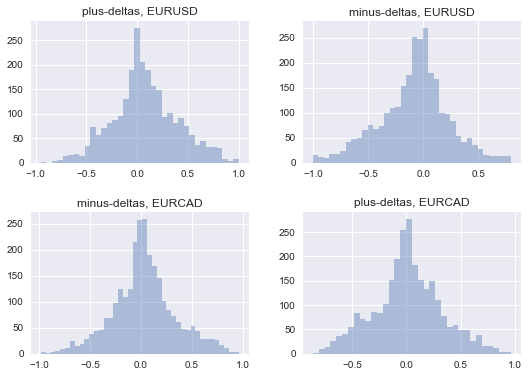

In [104]:
# Calculate ratio delta array
delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]
forwardshift = 10 # Hours
# Long and short abs-val target param
target = 0.0057

# Record data if price - target
price_delta_plus = []
price_delta_minus = []
for k in range(len(delta)-forwardshift):
    if cur1_col1[samplesize+k+forwardshift] >= cur1_col1[samplesize+k] + target:
        price_delta_plus.append(delta[k])
    elif cur1_col1[samplesize+k+forwardshift] <= cur1_col1[samplesize+k] - target:
        price_delta_minus.append(delta[k])

print('    plus minus')
print('USD', len(price_delta_plus), len(price_delta_minus))

import seaborn as sns
plt.figure(1)

plt.subplot(221)
plt.title('plus-deltas, EURUSD')
sns.distplot(price_delta_plus, kde=False)
plt.yscale('linear')
plt.grid(True)

plt.subplot(222)
plt.title('minus-deltas, EURUSD')
sns.distplot(price_delta_minus, kde=False)
plt.yscale('linear')
plt.grid(True)

# CAD target
target = 0.0075

price_delta_plus = []
price_delta_minus = []
for k in range(len(delta)-forwardshift):
    if cur2_col1[samplesize+k+forwardshift] >= cur2_col1[samplesize+k] + target:
        price_delta_plus.append(delta[k])
    elif cur2_col1[samplesize+k+forwardshift] <= cur2_col1[samplesize+k] - target:
        price_delta_minus.append(delta[k])

print('CAD', len(price_delta_plus), len(price_delta_minus))

plt.subplot(224)
plt.title('plus-deltas, EURCAD')
sns.distplot(price_delta_plus, kde=False)
plt.yscale('linear')
plt.grid(True)

plt.subplot(223)
plt.title('minus-deltas, EURCAD')
sns.distplot(price_delta_minus, kde=False)
plt.yscale('linear')
plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.35,
                    wspace=0.25)

print('\nStipulated that plus-delta profile for USD is most similar to minus-delta profile for CAD, vice versa')

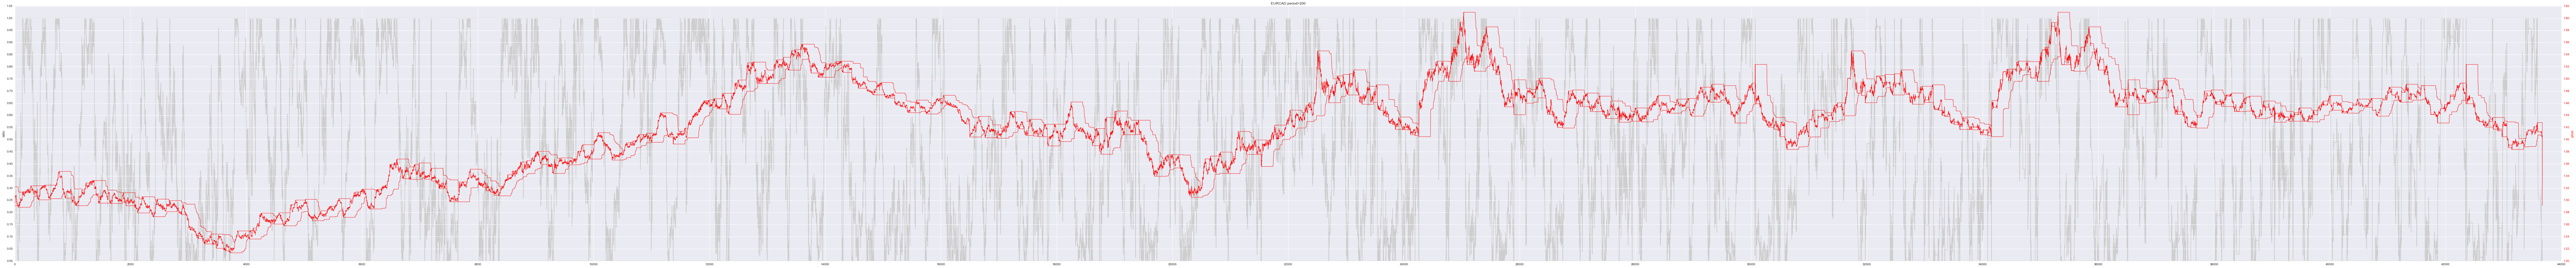

In [4]:
# Preparing to plot on multiple y-axes
fig = plt.figure(figsize=(150, 15))
ax1 = fig.add_subplot(111)

ax1.plot(other_ratio, '#cdcdcd')
ax1.plot([1]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.plot([0]*len(other_ratio), '#cdcdcd', linewidth=1.0)
ax1.set_ylabel('ratio')
ax1.locator_params(nbins=30)

# Add subplot with different axis range
ax2 = ax1.twinx()
ax2.plot(cur2_localmax, 'r', linewidth=1.0)
ax2.plot(cur2_localmin, 'r', linewidth=1.0)
ax2.plot(cur2_col1[samplesize:len(other_ratio)+samplesize], 'r', linewidth=1.0)
ax2.locator_params(nbins=30)
ax2.set_ylabel('price', color='r')
for tl in ax2.get_yticklabels():
    tl.set_color('r')

plt.title('EURCAD period=' + str(samplesize))
plt.xlabel('(ticks)')
#plt.show()
plt.savefig('EURCAD_coint.pdf')

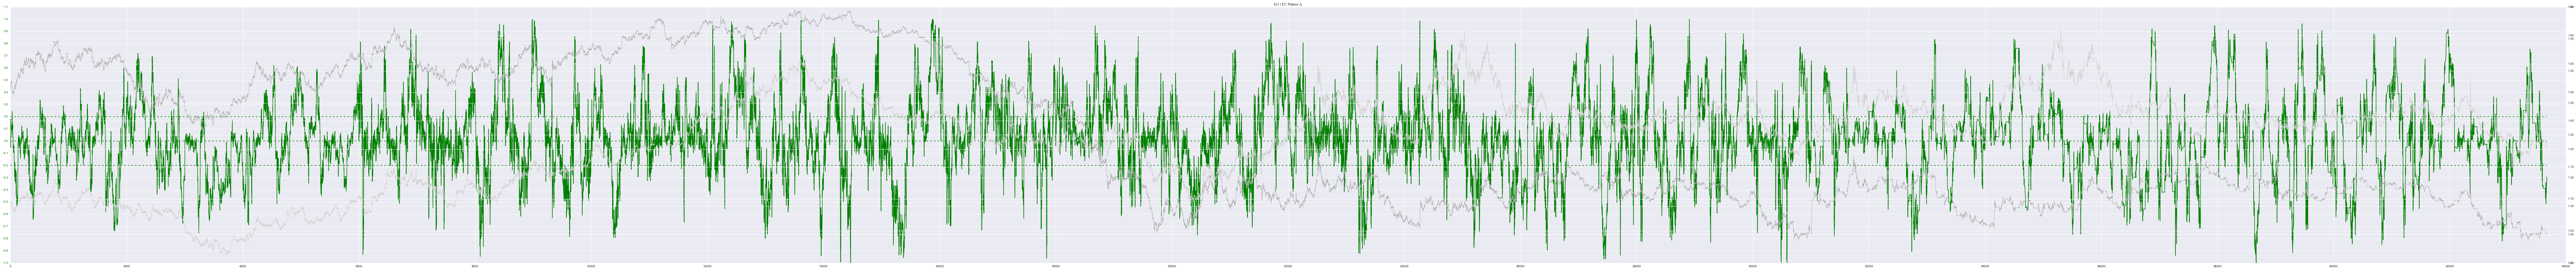

In [5]:
# Visualize ratio with currencies
# ---

fig2 = plt.figure(figsize=(150, 15))
ax2_1 = fig2.add_subplot(111)
ax2_2 = fig2.add_subplot(111)

# Plot delta with thresholds
ax2_2.plot(delta, 'g')
ax2_2.plot([0.2]*len(other_ratio), 'g--')
ax2_2.plot([0]*len(other_ratio), 'g--')
ax2_2.plot([-0.2]*len(other_ratio), 'g--')

for tl in ax2_1.get_yticklabels():
    tl.set_color('g')
'''
ax2_1.plot(this_ratio, 'r')
ax2_1.plot(other_ratio, 'b')
'''
ax2_1.twinx().plot(cur2_col1[samplesize:len(other_ratio)+samplesize], '#cdcdcd', linewidth=1.0)
ax2_1.twinx().plot(cur1_col1[samplesize:len(other_ratio)+samplesize], '#adadad', linewidth=1.0)
ax2_1.locator_params(nbins=30)
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()

In [75]:
# Simple backtesting engine for hedging pairs trading
# ---

class order():
    def order_open(self):
        pass
    def order_close(self):
        pass
    

trade_1 = 0 #EURUSD 
trade_2 = 0 #EURCAD
ev, ev_1, ev_2 = [0]*3 # iters
open_rates = [0]*2
entryvals =  [0]*len(delta)
typevals =   [0]*len(delta)

# Exitvals 1 & 2 because of positions on two symbols
exitvals_1 = [0]*len(delta)
exitvals_2 = [0]*len(delta)
net_pips_1 = [0]
net_pips_2 = [0]
np_1 = 1 #(net pips iter)
np_2 = 1

wins = 0
losses = 0

# Parameters
# > compute sl/tp as fraction of volatility / ML-smarts
deltaval = 0.5 #Threshold for Delta_ratios for trades
target_1 = 0.01
stop_1 = 0.005
target_2 = 1#0.01
stop_2 = 0.005

for x in range(len(delta)):
    # if all closed
    if trade_1 == trade_2 == 0:
        if delta[x] >= deltaval and delta[x] <= deltaval*1.5:
            tradetype = 1 # ><
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
            trade_2 = 1 # ''
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 1 # For line coloring in backtest visualization
            ev += 1

        elif delta[x] <= -deltaval and delta[x] >= deltaval*1.5:
            tradetype = 0 # <>
            open_rates[0] = cur1_col1[samplesize+x]
            open_rates[1] = cur2_col1[samplesize+x]
            # Trades = open
            trade_1 = 1 # Keeping track of both trades simultaneously, also allows different stops/targets
            trade_2 = 1 # ''
            entryvals[ev] = x # Store position in delta array
            typevals[ev] = 0 # For line coloring in backtest visualization
            ev += 1
            
    
    # if >0 open
    else:
        # ><
        if tradetype == 1:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[0] < cur1_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] <= open_rates[0] - stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
        
        # ><
        else:
            if trade_1 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    continue

                if cur2_col1[samplesize+x] >= open_rates[0] + target_2 or cur1_col1[samplesize+x] <= open_rates[0] - stop_2:
                    # > Adjust pips by EC/EU worth
                    net_pips_2.insert(np_2, net_pips_2[np_2-1] + (cur2_col1[samplesize+x] - open_rates[1])*10000)
                    np_2 += 1
                    trade_1 = 0
                    exitvals_1[ev_1] = x # Store position in delta array
                    ev_1 += 1
                    if open_rates[1] > cur2_col1[samplesize+x]:
                        losses += 1
                    else:
                        wins += 1
                    
            if trade_2 == 1:
                if -0.01 < delta[x] < 0.01:
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x] - 2:
                        losses += 1
                    else:
                        wins += 1
                    continue
                    
                if cur1_col1[samplesize+x] <= open_rates[0] - target_1 or cur1_col1[samplesize+x] >= open_rates[0] + stop_1:
                    # > Adjust pips by EC/EU worth
                    net_pips_1.insert(np_1, net_pips_1[np_1-1] + (open_rates[0] - cur1_col1[samplesize+x])*10000)
                    np_1 += 1
                    trade_2 = 0
                    exitvals_2[ev_2] = x # Store position in delta array
                    ev_2 += 1
                    if open_rates[0] < cur1_col1[samplesize+x] - 2:
                        losses += 1
                    else:
                        wins += 1

# Store rates in arrays
def getOpenRates(rate1, rate2):
    open_rates = [0]*2
    open_rates[0] = rate1
    open_rates[1] = rate2
    return open_rates

    '''
    >
    fix target issue
    improve spread consideration
        load historical spread data
    consider intrinsic pip value
    expand on class to simplify clause
        enable support for other strategies
    implement pyfolio support
    '''

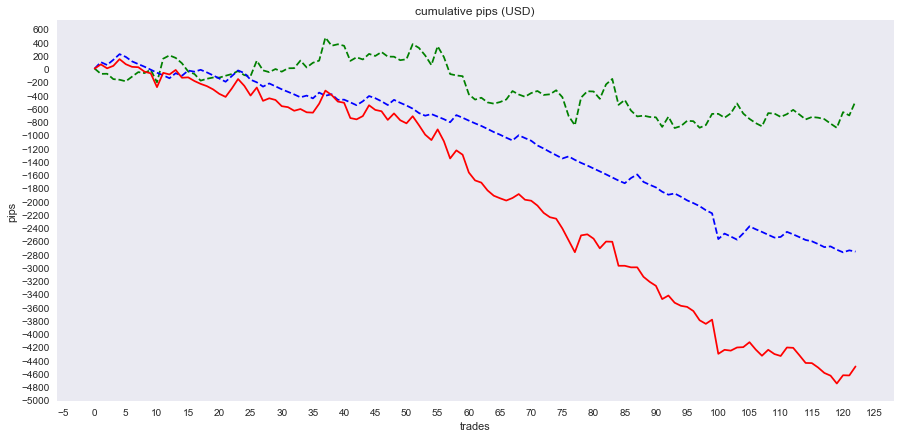

wins: 84
losses: 160
win%: 0.3442622950819672


In [76]:
# Profit plot
# ---

# 1.32 = EURCAD/EURUSD
# - 4 = 2 pips crossing 2 spreads

# > impl. net_pips_x for len
if len(net_pips_1) < len(net_pips_2):
    net_pips_x = len(net_pips_1)
else:
    net_pips_x = len(net_pips_2)
    
    
cumulative_net = [net_pips_2[i]*0.76 + net_pips_1[i] - 4*i for i in range(net_pips_x)]
net_pips_1_1 = [net_pips_1[j]*0.76 for j in range(net_pips_x)]

fig4 = plt.figure(figsize = (15, 7))
ax3 = fig4.add_subplot(111)
ax3.plot(net_pips_2, 'g--')
ax3.plot(net_pips_1_1, 'b--')
ax3.plot(cumulative_net, 'r')
ax3.locator_params(nbins=30)
plt.title('cumulative pips (USD)')
ax3.set_xlabel('trades')
ax3.set_ylabel('pips')
ax3.grid()
plt.show()

print('wins:', wins)
print('losses:', losses)

# out of whack
print('win%:', wins/(wins+losses))

In [8]:
print(net_pips_2[1])
print(net_pips_1[1])

128.3
82.6


Backtest Months: 4


Performance statistics   Backtest
annual_return                0.13
cum_returns_final            0.05
annual_volatility            0.04
sharpe_ratio                 3.18
calmar_ratio                10.65
stability_of_timeseries      0.88
max_drawdown                -0.01
omega_ratio                  1.70
sortino_ratio                5.38
skew                        -0.16
kurtosis                     1.55
tail_ratio                   1.87
common_sense_ratio           2.11
information_ratio            0.00
alpha                         nan
beta                          nan

Worst drawdown periods net drawdown in %  peak date valley date recovery date  \
0                                   1.20 2014-10-31  2014-12-15    2015-06-04   
1                                   0.77 2015-05-16  2015-08-07    2016-11-05   
2                                   0.71 2014-02-05  2014-06-24    2014-07-17   
3                                   0.64 2013-05-19  2013-11-06    2013-06-07   
4                                   0.54 2012-08-11  2013-06-02    2013-05-19   

Worst drawdown periods duration  
0                           155  
1                           385  
2                           116  
3                            15  
4                           200

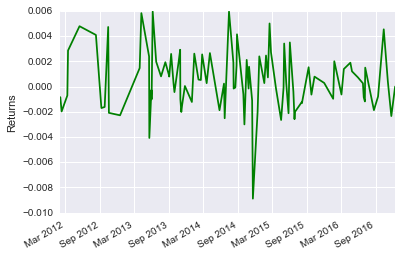

In [16]:
#https://github.com/quantopian/pyfolio/blob/master/pyfolio/examples/overview_slides.ipynb
trade_return = [0]

for i in range(0, len(cumulative_net)):
    trade_return.insert(i, (cumulative_net[i-1] - cumulative_net[i])/(cumulative_net[i]+50000))

# FFS index shit again. Assuming equal list len FUCK
ii = 0
entryvals_ = []
for i in range(len(entryvals)):
    if entryvals[i] > 0:
        entryvals_.insert(ii, entryvals[i])
        ii += 1
        
series = pd.Series(trade_return[2:], index=pd.DatetimeIndex(cur1_index[entryvals_]))
#print(series.tail())
series1 = series.copy()
series1.index.tz = 0
#plt.plot(series1)
#df = pyfolio.utils.get_symbol_rets('GOOGL')

from pyfolio import plotting, utils
#pyfolio.create_returns_tear_sheet(series1)#, benchmark_rets=None)
benchmark_rets = utils.get_symbol_rets('SPY')
plotting.show_perf_stats(series1, benchmark_rets)
plotting.show_worst_drawdown_periods(series1)
plotting.plot_returns(series1)
#pyfolio.create_bayesian_tear_sheet(series1, live_start_date='2015-01-05')

'''
Returns are currently calculated per trade. Pyfolio doesn't support heterogenous granularity. 
> Compound returns by date to increase metric acccuracy
'''

In [ ]:
df = pd.DataFrame(to_df)
print(df)


In [ ]:
print(len(trade_return))
print(len(to_index))

In [ ]:
# Plot approximate trade frequency
to_int = []
for nn in range(len(entryvals)):
    if nn > 0 and entryvals[nn] == 0:
        break
    to_int.insert(nn, entryvals[nn])

int_ = []
for evi in range(10, len(to_int), 10):
    int_.insert(evi, (to_int[evi] - to_int[evi-10])/10)

plt.plot(int_)
plt.plot([sum(int_)/len(int_)]*len(int_), '#afafaf')
plt.title('trade frequency')
plt.show()

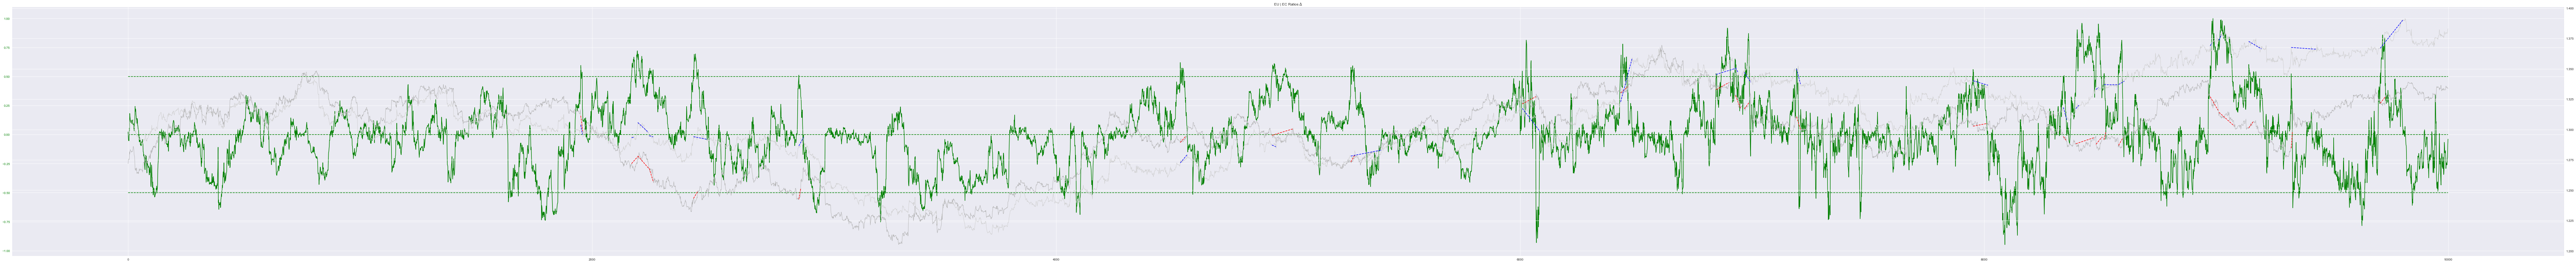

In [105]:
render_lim = 10000
render_shift = 0 #200000

fig6 = plt.figure(figsize=(150, 15))
#ax5_1 = fig5.add_subplot(111)
ax6_2 = fig6.add_subplot(111)

# Calculate ratio delta array
#delta = [other_ratio[i] - this_ratio[i] for i in range(len(other_ratio))]

# Plot delta with thresholds
ax6_2.plot(delta[render_shift:render_lim + render_shift], 'g')
ax6_2.plot([deltaval]*render_lim, 'g--')
ax6_2.plot([0]*render_lim, 'g--')
ax6_2.plot([-deltaval]*render_lim, 'g--')

for tl in ax6_2.get_yticklabels():
    tl.set_color('g')

# Plot correctly shifted quote values
#ax6_2.locator_params(nbins=30)
ax6_twinx = ax6_2.twinx()
ax6_twinx.plot(cur2_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#cdcdcd', linewidth=1.0)
ax6_twinx.plot(cur1_col1[samplesize + render_shift:render_lim + render_shift + samplesize], '#adadad', linewidth=1.0)

# Fast forward to correct entry/exit values in terms of render shift input
# Limiting backtester to a theoretical 99999 trades
for p in range(99999): 
    break

for k in range(render_lim):
    if exitvals_1[k] > render_lim and exitvals_2[k] > render_lim:
        break
    else:
        # Color trade-lines by type (<> | ><)
        if typevals[k] == 1:
            ax6_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'r--')
            ax6_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'b--')
        else:
            ax6_twinx.plot([entryvals[k], exitvals_1[k]], [cur1_col1[samplesize + entryvals[k]], cur1_col1[samplesize + exitvals_1[k]]], 'b--')
            ax6_twinx.plot([entryvals[k], exitvals_2[k]], [cur2_col1[samplesize + entryvals[k]], cur2_col1[samplesize + exitvals_2[k]]], 'r--')
        
plt.title('EU | EC Ratios $\Delta$')
plt.savefig('ratios_coint.pdf')
#plt.show()